In [2]:
from pyspark.sql import SparkSession
from IPython.display import display

In [3]:
spark = SparkSession.builder \
    .appName("Simple Example") \
    .master("local[*]") \
    .getOrCreate()
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/23 18:56:06 WARN Utils: Your hostname, mahdi-laptop, resolves to a loopback address: 127.0.1.1; using 172.17.71.223 instead (on interface wlo1)
25/12/23 18:56:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/23 18:56:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Q1.1

In [4]:
raw_data = sc.textFile("video_game_sales.csv")
header_raw = raw_data.first()
header = {column: index for index, column in enumerate(header_raw.split(','))}
raw_data = raw_data.filter(lambda line: line != header_raw) \
    .map(lambda line: line.split(',')) \
    .filter(lambda x: bool(x[header['title']]))
display(header)
display(raw_data.first())

{'img': 0,
 'title': 1,
 'console': 2,
 'genre': 3,
 'publisher': 4,
 'developer': 5,
 'critic_score': 6,
 'total_sales': 7,
 'na_sales': 8,
 'jp_sales': 9,
 'pal_sales': 10,
 'other_sales': 11,
 'release_date': 12,
 'last_update': 13}

['/games/boxart/full_6510540AmericaFrontccc.jpg',
 'Grand Theft Auto V',
 'PS3',
 'Action',
 'Rockstar Games',
 'Rockstar North',
 '9.4',
 '20.32',
 '6.37',
 '0.99',
 '9.85',
 '3.12',
 '2013-09-17',
 '']

In [46]:
def calc_total_sales(x):
    try:
        return (x[0], float(x[1]))
    except:
        pass
    
    try:
        return (x[0], sum(map(float, x[2:])))
    except:
        pass
    
    return None

top10_games = raw_data.map(lambda x: (x[header['title']], *x[7:12])) \
    .map(calc_total_sales) \
    .filter(lambda x: x != None) \
    .reduceByKey(lambda a, b: a+b) \
    .sortBy(lambda x: x[1], ascending=False)
    
display(top10_games.take(10))
display(top10_games.count())

[('"Warhammer 40', 124.69999999999999),
 ('Grand Theft Auto V', 64.29),
 ("You Don't Know Jack", 47.599999999999994),
 ('Call of Duty: Black Ops', 30.990000000000002),
 ('Call of Duty: Modern Warfare 3', 30.71),
 ('Call of Duty: Black Ops II', 29.590000000000003),
 ('Call of Duty: Ghosts', 28.800000000000004),
 ('Call of Duty: Black Ops 3', 26.72),
 ('Aggressive Inline', 26.610000000000003),
 ('The Lord of the Rings: The Return of the King', 26.46)]

12797

# Q1.2

In [28]:
def calc_sales_regen(x):
    sales = fix_sales_list(x[1:])
    if sales is None:
        return None
    else:
        return (x[0], sales)
        
def fix_sales_list(x):
    invalid_indices = []

    for i, item in enumerate(x):
        try:
            float(item)
        except:
            invalid_indices.append(i)

    if len(invalid_indices) > 1:
        return None
    elif len(invalid_indices) == 0:
        return list(map(float, x))

    missing_idx = invalid_indices[0]
    calculated_value = 0.0

    try:
        if missing_idx == 0:
            current_sum = 0.0
            for i in range(1, len(x)):
                current_sum += float(x[i])
            calculated_value = current_sum

        else:
            total_sum = float(x[0])
            current_sum = 0.0
            for i in range(1, len(x)):
                if i == missing_idx:
                    continue
                current_sum += float(x[i])
            
            calculated_value = total_sum - current_sum

        x[missing_idx] = calculated_value
        return list(map(float, x))

    except:
        return None
    
genre_per_regen = raw_data.map(lambda x: (x[header['genre']], *x[7:12])) \
    .map(calc_sales_regen) \
    .filter(lambda x: x != None) \
    .reduceByKey(lambda list1, list2: tuple(a + b for a, b in zip(list1, list2))) \
    # .sortBy(lambda x: x[1], ascending=False)
    
display(genre_per_regen.take(10))
display(genre_per_regen.count())

[('Action',
  (540.9100000000003,
   249.1300000000003,
   40.91000000000002,
   185.49,
   63.05000000000007)),
 ('Shooter',
  (632.3900000000002,
   302.38000000000056,
   22.82000000000005,
   210.76000000000008,
   75.88000000000002)),
 ('Sports',
  (395.73000000000025,
   137.72000000000006,
   31.35000000000007,
   168.14999999999998,
   58.650000000000034)),
 ('Role-Playing',
  (232.67, 103.58999999999996, 47.33, 59.1, 22.690000000000097)),
 ('Racing',
  (209.3700000000001,
   85.11999999999995,
   11.789999999999978,
   84.88999999999996,
   27.58000000000003)),
 ('Fighting',
  (162.08999999999997,
   69.79999999999998,
   22.470000000000013,
   36.099999999999994,
   14.429999999999968)),
 ('Adventure',
  (78.28000000000004,
   33.93000000000003,
   9.149999999999999,
   27.490000000000023,
   7.679999999999995)),
 ('Music', (5.460000000000001, 3.2, 0.63, 1.03, 0.5700000000000002)),
 ('Party', (16.25, 2.11, 0.83, 0.6000000000000001, 0.67)),
 ('Action-Adventure',
  (91.71000000

20

/tmp/ipykernel_131192/2835966677.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_regions)


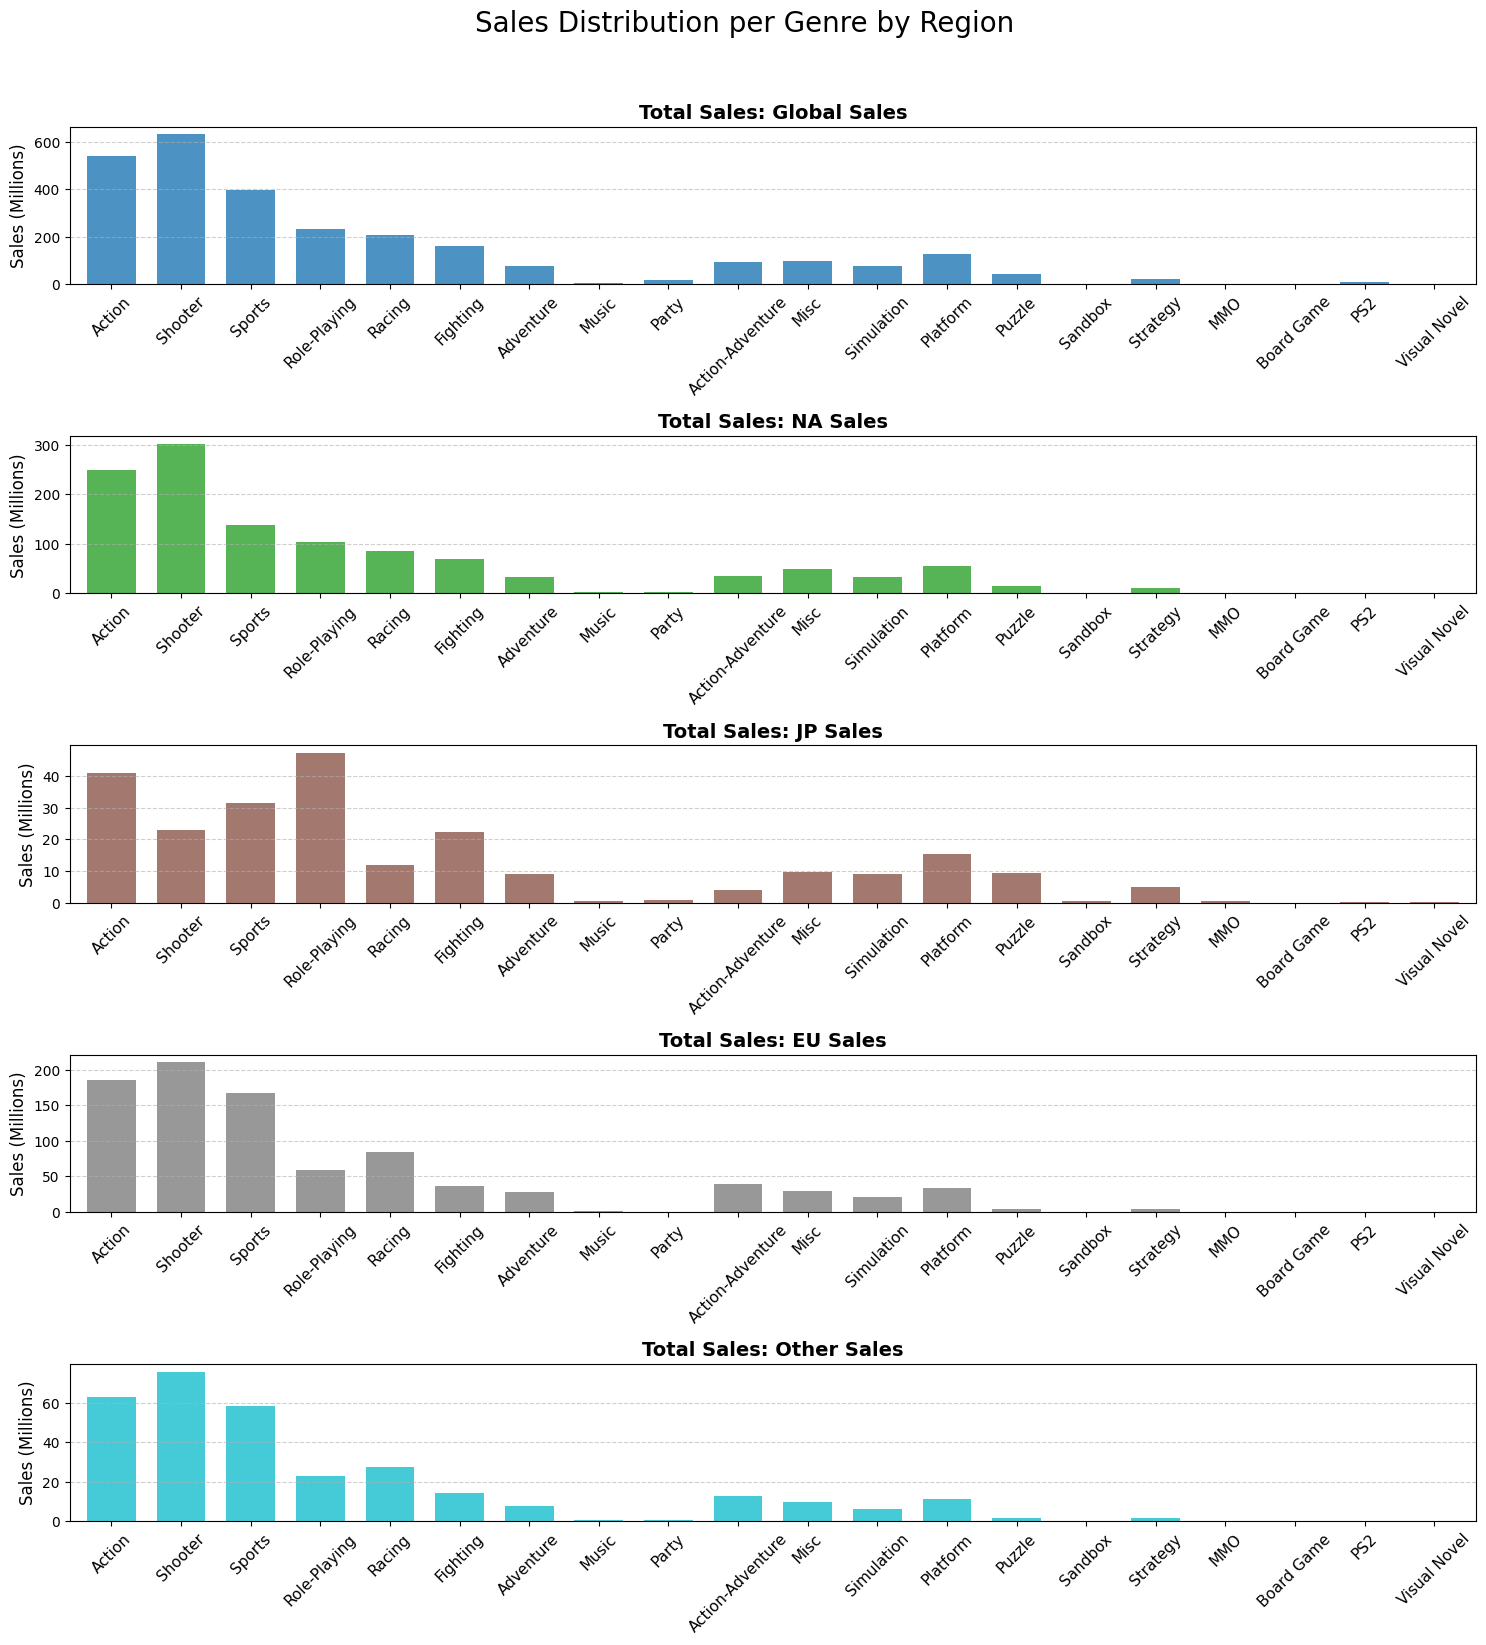

In [38]:
# https://gemini.google.com/share/a3cd334caba0
import matplotlib.pyplot as plt
import pandas as pd

collected_data = genre_per_regen.collect()

genres = [row[0] for row in collected_data]
values = [list(row[1]) for row in collected_data]

region_names = ['Global Sales', 'NA Sales', 'JP Sales', 'EU Sales', 'Other Sales']

df = pd.DataFrame(values, columns=region_names, index=genres)

num_regions = len(region_names)
nrows = 6
ncols = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))
axes_flat = axes.flatten()

colors = plt.cm.get_cmap('tab10', num_regions)

for i, region_col in enumerate(df.columns):
    ax = axes_flat[i]
    df[region_col].plot(kind='bar', ax=ax, color=colors(i), alpha=0.8, width=0.7)
    
    ax.set_title(f'Total Sales: {region_col}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Sales (Millions)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45, labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Sales Distribution per Genre by Region", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# Q1.3

In [52]:
def is_float(x):
    try:
        float(x[header['critic_score']])
        return True
    except:
        return False
    
def calc_total_sales(x):
    try:
        return float(x[header['total_sales']])
    except:
        pass
    
    try:
        return sum(map(float, x[header['total_sales']+1: header['other_sales']+1]))
    except:
        pass
    
    return 0


MIN_SALES = 10
have_score = raw_data.filter(is_float) \
    .map(lambda x: (x[header['developer']], (calc_total_sales(x), float(x[header['critic_score']]), 1))) \
    .reduceByKey(lambda list1, list2: tuple(a + b for a, b in zip(list1, list2))) \
    .mapValues(lambda x: (x[0], x[1]/x[2])) \
    .filter(lambda x: x[1][0] >= MIN_SALES) \
    .sortBy(lambda x: x[1][1], ascending=False)
    
display(have_score.take(10))
display(have_score.count())

[('Rockstar Games', (13.94, 9.8)),
 ('Naughty Dog', (20.14, 9.083333333333334)),
 ('Rockstar North', (99.57000000000001, 9.060869565217393)),
 ('Rocksteady Studios', (22.59, 9.025)),
 ('Bungie', (13.38, 8.9)),
 ('Turn 10 Studios', (12.120000000000001, 8.899999999999999)),
 ('Rockstar San Diego', (22.27, 8.722222222222221)),
 ('Dice', (17.32, 8.633333333333333)),
 ('Harmonix Music Systems', (29.330000000000002, 8.544)),
 ('EA Digital Illusions CE', (12.250000000000002, 8.48))]

59